In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ARDRegression
import random
random.seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
init_data1 = pd.read_excel("./phc_mo3_and_tripms.xls")
init_data2 = pd.read_excel("./PhC_MO3_and_tripms2.xls")
init_data3 = pd.read_excel("./PhC_MO3_and_tripms3.xls")

main_features2 = init_data2.copy()
for col in main_features2:
    if (col != 'PhC') & (col[0] != 't'):
        main_features2.drop(columns=[col], inplace=True)

main_features2["Cycle"] = init_data2['Unnamed: 1']

main_features2["Real_PhC"]  = np.zeros(main_features2.shape[0])
main_features2["Real_PhC"][0:-2:1] = main_features2['PhC'][1:-1:1]

# main_features2.drop(inplace=True, axis='rows')

main_features2[np.isnan(main_features2)] = 0

main_features2.drop(index=main_features2.index[main_features2['Real_PhC'] == 0], inplace=True)

# print(main_features2['Real_PhC'][main_features2['Real_PhC'].idxmin()])
main_features2.head(20)

,PhC,"t1(passive,slow)","t2(passive,fast)","t3(active,slow)","t4(active,fast)",Cycle,Real_PhC
17,0.000000,153.846512,316.010203,3437.961850,2024.176166,3.0,0.368382
18,0.368382,786.342177,77.156605,1771.759692,893.738942,4.0,0.411326
20,0.000000,545.487015,261.629143,1873.728844,1714.151515,4.0,0.342096
24,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,0.388945
25,0.388945,0.000000,0.000000,0.000000,0.000000,5.0,0.367687
26,0.367687,643.769583,276.212507,1767.446580,890.568173,6.0,0.404209
28,0.000000,615.937749,166.170172,1237.616204,1712.271861,6.0,0.314929
30,0.000000,708.365771,197.774011,1773.355578,891.494309,7.0,0.336423
31,0.336423,1135.819101,961.948224,1328.705175,586.525000,7.0,0.352973
32,0.352973,582.269316,385.380876,2416.592410,1713.753680,7.0,0.358951


In [19]:
USE_GPU = False # на моём текущем устройстве не поддерживается новый пайторч

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [20]:
def max_line(target):
    figure = plt.figure(figsize=(5,5))
    mx = target[np.argmax(target)]
    mn = target[np.argmin(target)]
    sns.lineplot((mn, mx),(mn, mx))

In [21]:
from networks.model import train
from networks.Dataset import MyDataset

def test_model(model, train_set, X_test, y_test, batch_size=20, num_epochs=10):
    model.train()
    %time train(model, train_set, batch_size, epochs=num_epochs)

    model.eval()
    y_pred = model.forward(torch.Tensor(np.asarray(X_test, dtype=np.float64))).detach().numpy().squeeze()
    
    sns.scatterplot(train_set.target, model.forward(torch.Tensor(np.asarray(X_train, dtype=np.float64))).detach().numpy().squeeze()) 
#     sns.scatterplot(y_test, y_pred)
    return test_accuracy(y_test, y_pred)

In [22]:
def test_accuracy(y_test, y_pred):
    loss = np.mean(np.abs(y_pred.squeeze() - y_test.values))
    print("ошибка текущей модели: %.15e" % loss)
    sns.scatterplot(y_test, y_pred)
    
    plt.xlabel('ФС')
    plt.ylabel('Прогноз')
    return loss

# Naive dataset

REGRESSION TREES

In [23]:
X = main_features2.drop(['Real_PhC', 'PhC', 'Cycle'], axis='columns')
y = main_features2['Real_PhC'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [24]:
X_train.shape

(52, 4)

In [25]:
tree = DecisionTreeRegressor(criterion='mae', random_state=42)
cross_val_score(tree, X_train, y_train, cv=3)

array([-0.7107154 , -0.62573458, -1.71595484])

ошибка текущей модели: 1.797011510264827e-03
ошибка текущей модели: 3.197692886578390e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.031976928865783905

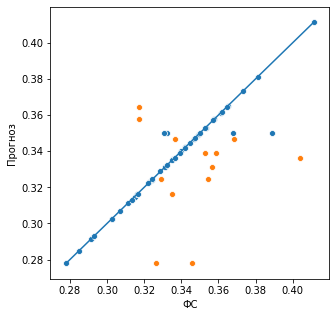

In [26]:
tree.fit(X_train, y_train)
max_line(y)
y_pred = tree.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = tree.predict(X_test)
test_accuracy(y_test, y_pred)

Linear Regression


In [27]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
linear = LinearRegression()
lasso = lasso.fit(X_train, y_train)
ridge = ridge.fit(X_train, y_train)
linear = linear.fit(X_train, y_train)

ошибка текущей модели: 2.108257852172953e-02
ошибка текущей модели: 2.049115787456648e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.02049115787456648

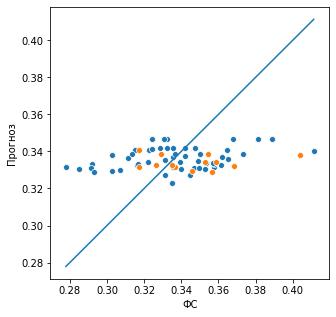

In [28]:
max_line(y)
y_pred = lasso.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = lasso.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 2.158815049607707e-02
ошибка текущей модели: 2.063248541001528e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.020632485410015285

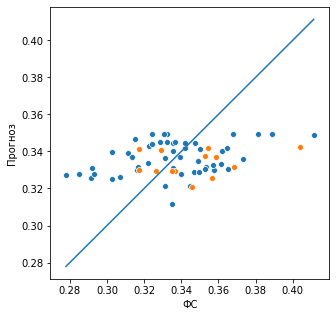

In [29]:
max_line(y)
y_pred = ridge.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = ridge.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 2.158815072645974e-02
ошибка текущей модели: 2.063248515613731e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.02063248515613731

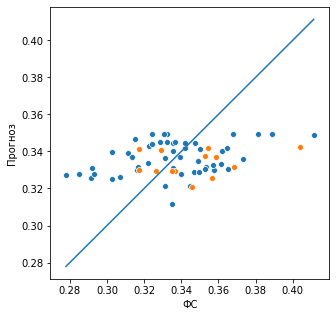

In [30]:
max_line(y)
y_pred = linear.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = linear.predict(X_test)
test_accuracy(y_test, y_pred)

In [31]:
net = nn.Sequential(
    nn.BatchNorm1d(4),
    nn.Linear(4,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64,1)
)

In [32]:
train_set = MyDataset(train_data=X_train, train_target=y_train)
num_epochs = 100
batch_size = 16

/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


CPU times: user 8.82 s, sys: 41.3 ms, total: 8.86 s
Wall time: 1.62 s
ошибка текущей модели: 1.923813844127050e-02


0.019238138441270498

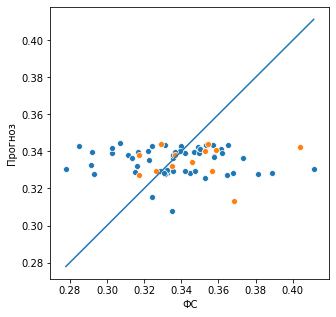

In [33]:
max_line(y)
test_model(net, train_set, X_test, y_test, batch_size, num_epochs)

# previous day dataset

In [34]:
main_features1 = init_data1.drop(columns=['Forecast', 'day number', 'Speed','Heart rate','Load','Avg PhC 9days', 'Avg PhC 3days',
'Avg Forecast 3 days','Unnamed: 13','Unnamed: 14','Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 
                        'Unnamed: 19'], axis=0)
main_features1.drop(labels=range(11), inplace=True)
main_features1.dropna(inplace=True)

main_features1['Real_PhC'] = np.zeros(main_features1.shape[0])
main_features1['Real_PhC'][1:-1:1] = main_features1['Physiological Cost (PhC)'][0:-2:1]

main_features1['Prev_PhC'] = np.zeros(main_features1.shape[0])
main_features1['Prev_PhC'][1:-1:1] = main_features1['Real_PhC'][0:-2:1]

main_features1.drop(index=main_features1.index[main_features1['Real_PhC'] == 0], inplace=True)

main_features1.drop(index=main_features1.index[0:2], inplace=True)
main_features1.drop(columns=['Physiological Cost (PhC)'], inplace=True)
main_features1.head(15)

/home/vyacheslav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/vyacheslav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,TRIMP1,TRIMP2,TRIMP3,TRIMP4,Real_PhC,Prev_PhC
14,809.691,13.2364,1778.61,880.455,0.354685,0.353656
15,769.12,26.4721,1773.54,887.856,0.330189,0.354685
17,738.895,1.30417,2444.16,1676.64,0.371243,0.330189
18,670.607,10.3701,1779.52,877.502,0.319281,0.371243
19,722.044,51.7193,1776.15,889.079,0.347529,0.319281
21,812.129,15.1143,2433.37,1713.38,0.367796,0.347529
22,806.386,40.4501,1772.26,890.899,0.367804,0.367796
23,766.522,53.6372,1784.37,870.461,0.364584,0.367804
24,1522.22,190.882,1310.97,582.917,0.354662,0.364584
25,667.532,174.922,2442.51,1709.02,0.320565,0.354662


In [35]:
X = main_features1.drop(columns=['Real_PhC'])
y = main_features1['Real_PhC'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [36]:
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
linear = LinearRegression()
tree = DecisionTreeRegressor(criterion='mae', random_state=42)
tree.fit(X_train, y_train)
lasso = lasso.fit(X_train, y_train)
ridge = ridge.fit(X_train, y_train)
linear = linear.fit(X_train, y_train)

ошибка текущей модели: 0.000000000000000e+00
ошибка текущей модели: 1.950460319999999e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.019504603199999995

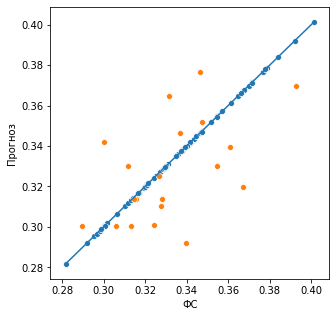

In [37]:
max_line(y)
y_pred = tree.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = tree.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 1.959286098378393e-02
ошибка текущей модели: 1.823820149078616e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.018238201490786164

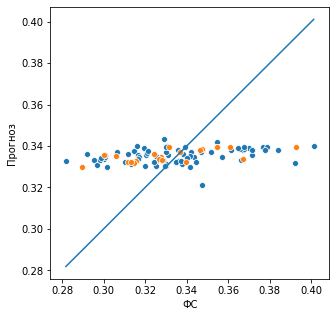

In [38]:
max_line(y)
y_pred = lasso.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = lasso.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 1.904553651910265e-02
ошибка текущей модели: 1.641612094245345e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.016416120942453448

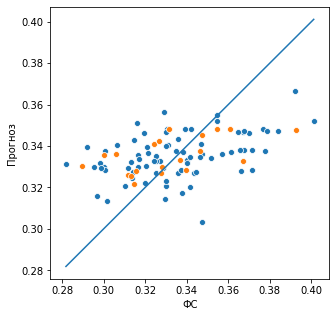

In [39]:
max_line(y)
y_pred = ridge.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = ridge.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 1.905693362271197e-02
ошибка текущей модели: 1.693532081614410e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.016935320816144104

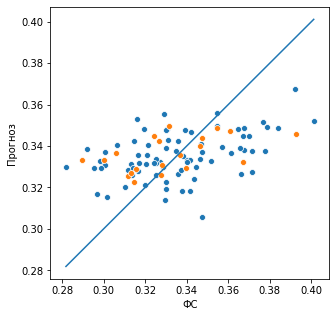

In [40]:
max_line(y)
y_pred = linear.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = linear.predict(X_test)
test_accuracy(y_test, y_pred)

In [41]:
net = nn.Sequential(
    nn.BatchNorm1d(5),
    nn.Linear(5,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64,1)
)

/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


CPU times: user 11 s, sys: 52.8 ms, total: 11 s
Wall time: 2 s
ошибка текущей модели: 2.584051136009293e-02


0.025840511360092928

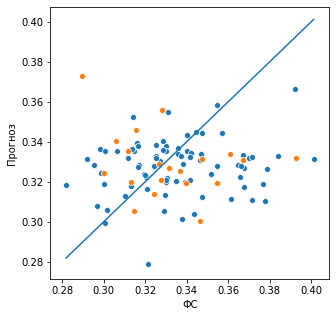

In [42]:
max_line(y)
train_set = MyDataset(train_data=X_train, train_target=y_train)
test_model(net, train_set, X_test, y_test, batch_size, num_epochs)

# Cycle days dataset


In [43]:
main_features3 = init_data3.copy()
for col in main_features3:
    if (col != 'PhC') & (col[0] != 't'):
        main_features3.drop(columns=[col], inplace=True)
        
main_features3['Real_PhC'] = np.zeros(main_features3.shape[0])
main_features3['Real_PhC'][1:-1:1] = main_features3['PhC'][0:-2:1]
main_features3.drop(columns=['PhC'], inplace=True)

main_features3["Cycle"] = init_data2['Unnamed: 1']
main_features3["cyc_day"] = init_data3['Unnamed: 2'] // 100 + 1

main_features3["cyc_day_1"] = np.zeros(main_features3.shape[0])
main_features3["cyc_day_2"] = np.zeros(main_features3.shape[0])
main_features3["cyc_day_3"] = np.zeros(main_features3.shape[0])

for i in main_features3.index:
    if not np.isnan(main_features3["cyc_day"][i]):
        main_features3["cyc_day_"+str(int(main_features3["cyc_day"][i]))][i] = 1

main_features3.dropna(inplace=True)

# for i in range(main_features3.shape[0]): запустить на полных циклах
    

main_features3.drop(columns=['Cycle', 'cyc_day'], inplace=True)

print(main_features3.shape)
main_features3.head(10)

(83, 8)


,"t1(passive,slow)","t2(passive,fast)","t3(active,slow)","t4(active,fast)",Real_PhC,cyc_day_1,cyc_day_2,cyc_day_3
33,621.926554,53.072229,1984.432684,1712.556739,0.372696,0.0,1.0,0.0
34,811.103615,22.553583,1316.121691,890.204572,0.474150,0.0,0.0,1.0
35,1440.247939,460.742262,906.896449,587.109338,0.446676,1.0,0.0,0.0
37,721.064555,115.665511,1315.034756,895.210557,0.462178,0.0,0.0,1.0
39,480.045496,219.343924,2001.282949,1678.310272,0.439352,0.0,1.0,0.0
40,560.373593,311.105758,1319.198824,887.306780,0.443918,0.0,0.0,1.0
41,1097.596709,881.267415,911.701334,585.403947,0.480746,1.0,0.0,0.0
42,527.184820,166.336664,1975.086037,1711.362546,0.458545,0.0,1.0,0.0
43,694.813064,158.436406,1313.837434,891.898987,0.440613,0.0,0.0,1.0
44,754.286057,222.693012,1039.998877,0.000000,0.497432,1.0,0.0,0.0


In [44]:
X = main_features3.drop(columns=['Real_PhC'])
y = main_features3['Real_PhC'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [45]:
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
linear = LinearRegression()
tree = DecisionTreeRegressor(criterion='mae', random_state=42)
tree.fit(X_train, y_train)
lasso = lasso.fit(X_train, y_train)
ridge = ridge.fit(X_train, y_train)
linear = linear.fit(X_train, y_train)

ошибка текущей модели: 0.000000000000000e+00
ошибка текущей модели: 4.485633280370966e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.04485633280370966

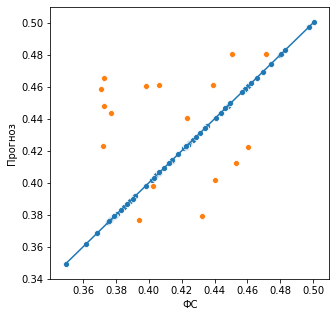

In [46]:
max_line(y)
y_pred = tree.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = tree.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 2.835454919898081e-02
ошибка текущей модели: 3.105799031357311e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.03105799031357311

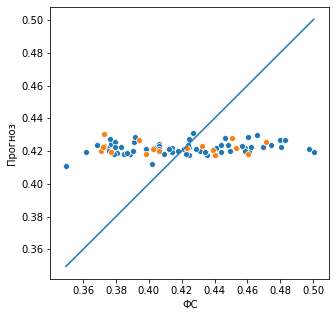

In [47]:
max_line(y)
y_pred = lasso.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = lasso.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 2.702585580922578e-02
ошибка текущей модели: 3.510950650169641e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.03510950650169641

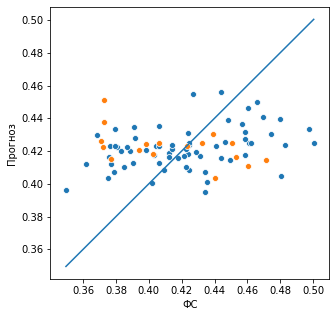

In [48]:
max_line(y)
y_pred = ridge.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = ridge.predict(X_test)
test_accuracy(y_test, y_pred)

ошибка текущей модели: 2.700741701183477e-02
ошибка текущей модели: 3.524515697391927e-02


/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


0.03524515697391927

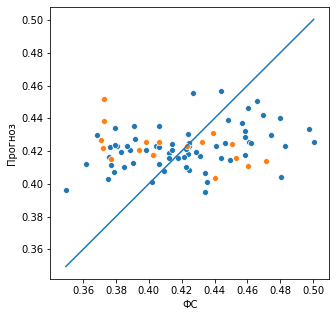

In [50]:
max_line(y)
y_pred = linear.predict(X_train)
test_accuracy(y_train, y_pred)
y_pred = linear.predict(X_test)
test_accuracy(y_test, y_pred)

In [51]:
net = nn.Sequential(
    nn.BatchNorm1d(7),
    nn.Linear(7,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64,1)
)

/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/vyacheslav/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


CPU times: user 11 s, sys: 88 ms, total: 11.1 s
Wall time: 2.07 s
ошибка текущей модели: 3.829193824089466e-02


0.03829193824089466

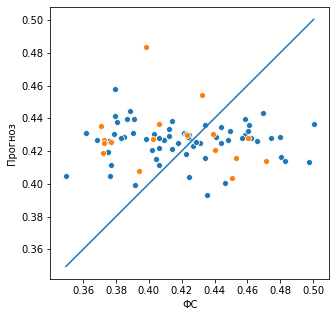

In [52]:
max_line(y)
train_set = MyDataset(train_data=X_train, train_target=y_train)
test_model(net, train_set, X_test, y_test, batch_size, num_epochs)